In [1]:
import numpy as np
import matplotlib.pyplot as plt
import utils
import scipy.spatial as spatial
import json
from random import choice, sample
from tqdm.notebook import tqdm
from rdkit import Chem
from rdkit.Chem import Descriptors
from gc import collect
from more_itertools import powerset
from itertools import combinations
from rich import print

with open("data/aspartam_similar_CFMID4.0.json", mode = "r") as drugbank:
    db = json.load(drugbank)

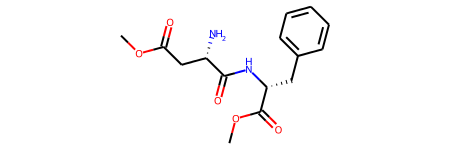

In [2]:
#mol_str = choice(list(db.keys()))
mol_str = "COC(=O)C[C@H](N)C(=O)N[C@H](Cc1ccccc1)C(=O)OC"
Chem.MolFromSmiles(mol_str)

In [3]:
mol_strings = [mol_str]
spectra = dict()
for m in tqdm(mol_strings):
    energies = [
        np.asarray([ utils.split_fpn(x) for x in db[m]["energy0"]["mz"] ]),
        np.asarray([ utils.split_fpn(x) for x in db[m]["energy1"]["mz"] ]),
        np.asarray([ utils.split_fpn(x) for x in db[m]["energy2"]["mz"] ])
    ]
    for i,energy in enumerate(energies):
        energies[i][:,0] = np.log(energy[:,0])/np.log(6000)
        
    spectra[m] = tuple(energies)

mol_strings = list(spectra.keys())

  0%|          | 0/1 [00:00<?, ?it/s]

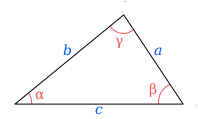
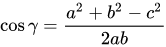

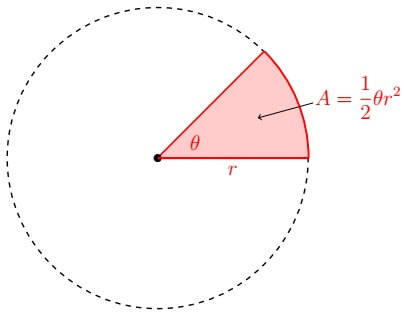

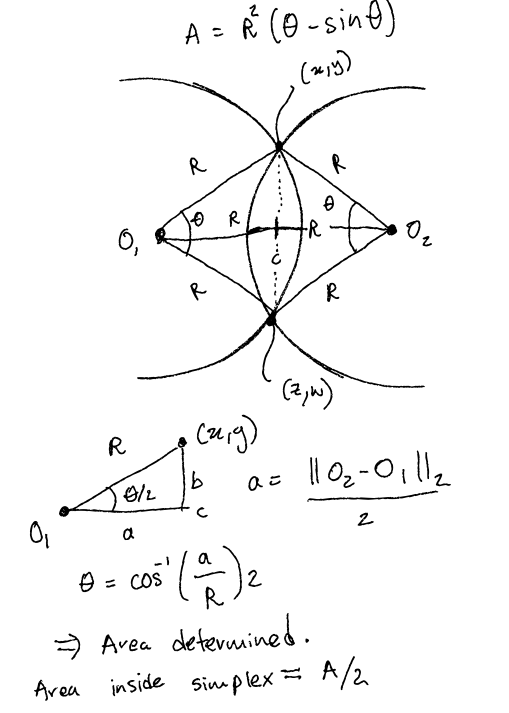

In [4]:
sizes = list()

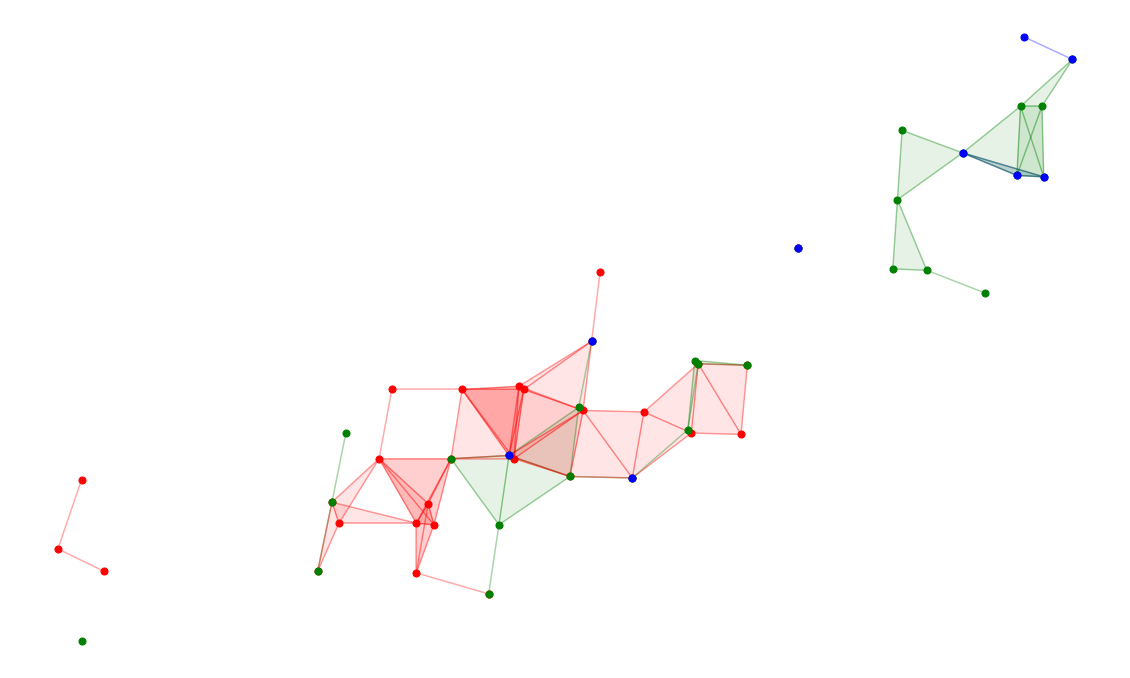

In [59]:
%matplotlib inline
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot()


def plot_lines(ax, kdtree, cloud, color, radius):
    lines = list()
    
    # plot lines
    for pair in kdtree.query_pairs(radius):
        lines.append(pair)
        
        a, b = cloud[pair[0]], cloud[pair[1]]
        ax.plot(
            [a[0],b[0]],
            [a[1],b[1]],
            "-",
            color = color,
            alpha = .333
        )
        
    return set(lines)
        
def plot_circles(ax, cloud, color, radius):
    for x in cloud:
        circle = plt.Circle(x, radius, ls = "--", color = color, fill = False, alpha = .333)
        ax.add_patch(circle)

def plot_triangles(ax, lines, cloud, color, radius):
    # if the area of the triangle is larger than the sum of the area of
    # the sectors, then the 3 circles do not overlap (and vice versa)
    #.... this can be generalized to higher dimensions..! sector = sector of a sphere ... etc (volumes..)
    # (but it is very simple for 2D)
    #
    # the trielle is the "middle" when all balls intersect
    #
    # for a tetrahedron the lens is a lemon, and the sector is a "sector" of a sphere
    
    def _area(a,b,c,radius):
        gamma = np.arccos((a**2 + b**2 - c**2)/(2*a*b))
        alpha = np.arccos((b**2 + c**2 - a**2)/(2*b*c))
        beta  = np.pi - gamma - alpha
        
        sector_areas = np.asarray(list(map(lambda theta : .5*theta*(radius**2), [gamma, alpha, beta])))
        
        lengths = np.asarray([a,b,c])/2
        theta = np.arccos(lengths/radius)*2 # theta for all 3 lenses
        lens_areas = (radius**2)*(theta - np.sin(theta))/2
        
        return sector_areas.sum() - lens_areas.sum()
    
    for tri in combinations(list(range(cloud.shape[0])), 3):
        tri_lines = list(combinations(tri, 2))
        edges = cloud[tri_lines, :]
        a,b,c = tuple(map(lambda e : np.linalg.norm(e[0,:] - e[1,:], ord = 2), edges))
        
        if len(lines.intersection(set(tri_lines))) == 3:
            
            A = _area(a,b,c,radius)
            A2 = _area(a,b,c,radius*1.0001) # this factor is like "plotting accuracy"
            
            trielle_formed = A2 < A
            
            if trielle_formed:
                t = plt.Polygon(cloud[tri,:], color = color, alpha = .1)
                ax.add_patch(t)

for mol_s in sample(mol_strings, min(len(mol_strings), 100) ):
    (X0,X1,X2) = spectra[ mol_s ]
    B,G,R = list(map(spatial.KDTree, [X0, X1, X2]))

    radius = 0.0099
    #radius = 0.017 # not a triangle yet
    #radius = 0.0179
    

    lines = plot_lines(ax, B, X0, "blue", radius*2)
    plot_triangles(ax, lines, X0, "blue", radius)
    
    lines = plot_lines(ax, G, X1, "green", radius*2)
    plot_triangles(ax, lines, X1, "green", radius)
    
    lines = plot_lines(ax, R, X2, "red", radius*2)
    plot_triangles(ax, lines, X2, "red", radius)

    #plot_circles(ax, X0, "blue", radius)
    #plot_circles(ax, X1, "green", radius)
    #plot_circles(ax, X2, "red", radius)

    #for i,x in enumerate(X0):
    #    ax.text(*tuple(x), str(i))
    
    ax.scatter(X2[:,0],X2[:,1], color = "red", s = 50,zorder = np.inf)
    ax.scatter(X1[:,0],X1[:,1], color = "green", s = 50,zorder = np.inf)
    ax.scatter(X0[:,0],X0[:,1], color = "blue", s = 50,zorder = np.inf)
    

    ax.set_aspect('equal')
    ax.set_xlabel("log_6000(integer mass)")
    ax.set_ylabel("decimal mass")
    ax.axis("off")
    
plt.show()